In [ ]:
import logging
from pathlib import Path
from typing import Dict, List, Optional, Tuple
from papermage.rasterizers import PDF2ImageRasterizer
from papermage import Document
import argparse
import json

logger = logging.getLogger(__name__)

def setup_logging(debug: bool = True):
    """Set up logging configuration."""
    log_level = logging.DEBUG if debug else logging.INFO
    logging.basicConfig(
        level=log_level,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    )
    # Quiet noisy loggers
    logging.getLogger('papermage').setLevel(logging.WARNING)
    logging.getLogger('pdfminer').setLevel(logging.WARNING)
    logging.getLogger('PIL').setLevel(logging.WARNING)
    logging.getLogger('pdf2image').setLevel(logging.WARNING)
    logging.getLogger('camelot').setLevel(logging.WARNING)
    logging.getLogger('pdfplumber').setLevel(logging.WARNING)
    logging.getLogger('pypdfium2').setLevel(logging.WARNING)

def load_or_parse_document(pdf_path: Path, cache_dir: Optional[Path] = None) -> Document:
    """
    Load a parsed document from cache or parse it fresh if needed.
    
    Args:
        pdf_path: Path to the PDF file
        cache_dir: Directory to store parsed documents (defaults to pdf's parent dir)
        
    Returns:
        Parsed Document instance
    """
    if cache_dir is None:
        cache_dir = pdf_path.parent
        
    # Create cache filename based on PDF path
    cache_path = cache_dir / f"{pdf_path.stem}_parsed.json"
    logger.debug(f"Looking for cached document at {cache_path}")
    
    if cache_path.exists():
        try:
            logger.debug("Found cached document, loading...")
            with open(cache_path, 'r') as f:
                doc = Document.from_json(json.load(f))
            logger.debug("Successfully loaded cached document")
            return doc
        except Exception as e:
            logger.warning(f"Failed to load cached document: {e}")
    
    # Parse document if not cached or cache loading failed
    logger.debug("Parsing document fresh...")
    from papermage.recipes import CoreRecipe
    recipe = CoreRecipe()
    doc = recipe.run(str(pdf_path))
    
    # Save to cache
    try:
        logger.debug("Saving parsed document to cache...")
        with open(cache_path, 'w') as f:
            json.dump(doc.to_json(), f, indent=4)
        logger.debug("Successfully cached parsed document")
    except Exception as e:
        logger.warning(f"Failed to cache parsed document: {e}")
    
    return doc

def extract_figures(doc: Document, output_folder: Path) -> Dict[str, Path]:
    """
    Extract figures from a parsed document.
    
    Args:
        doc: Parsed papermage Document
        output_folder: Where to save extracted figures
        
    Returns:
        Dictionary mapping figure IDs to their saved paths
    """
    logger.debug(f"Extracting figures to {output_folder}")
    figures: Dict[str, Path] = {}
    
    try:
        rasterizer = PDF2ImageRasterizer()
        
        for page_num, page in enumerate(doc.pages):
            logger.debug(f"Processing page {page_num}, found {len(page.images)} images")
            
            for fig_num, figure in enumerate(page.images):
                figure_id = f"fig_{page_num}_{fig_num}"
                logger.debug(f"Processing {figure_id}")
                
                # Find associated caption
                caption_found = False
                for caption in page.captions:
                    if caption.text:
                        logger.debug(f"Found caption for {figure_id}: {caption.text[:100]}...")
                        caption_found = True
                        break
                
                if not caption_found:
                    logger.debug(f"No caption found for {figure_id}")
                    continue
                
                # Save the figure
                figure_path = output_folder / f"{figure_id}.png"
                try:
                    # TODO: Implement actual figure extraction using rasterizer
                    # This will depend on how your figures are stored in the document
                    figures[figure_id] = figure_path
                    print(figure)

                    # extract figure from rasterizer using bounding boxes
                    figure_image = rasterizer.extract_figure(figure, caption)
                    
                    logger.debug(f"Saved figure to {figure_path}")
                except Exception as e:
                    logger.error(f"Failed to save figure {figure_id}: {e}")
                    
    except Exception as e:
        logger.error(f"Error during figure extraction: {e}")
        
    return figures

def create_thumbnail(
    pdf_path: Path,
    output_path: Path,
    mode: str = 'full',
    doc: Optional[Document] = None
) -> Optional[Path]:
    """
    Create a thumbnail from the first page of a PDF.
    
    Args:
        pdf_path: Path to the PDF file
        output_path: Where to save the thumbnail
        mode: 'full' or 'abstract'
        doc: Optional parsed Document for abstract detection
        
    Returns:
        Path to created thumbnail or None if failed
    """
    logger.debug(f"Creating thumbnail from {pdf_path} in {mode} mode")
    
    try:
        logger.debug("Initializing PDF rasterizer...")
        rasterizer = PDF2ImageRasterizer()
        logger.debug("Rasterizing first page...")
        rasterized_image = rasterizer.rasterize(str(pdf_path), 300)
        
        if not rasterized_image or not rasterized_image[0]:
            raise ValueError("Rasterization failed")
            
        page_image = rasterized_image[0].pilimage
        im_w, im_h = page_image.size
        logger.debug(f"Page dimensions: {im_w}x{im_h}")
        
        # Calculate bounds based on mode
        if mode == 'full':
            l, t = 0.075, 0.075  # Small margin from edges
            w, h = 0.85, 0.3     # Wide width, moderate height
            
            # Try to use abstract for bottom bound if available
            if doc and doc.pages and doc.pages[0].abstracts:
                abstract_bbox = doc.pages[0].abstracts[0].boxes[0]
                h = (abstract_bbox.t + abstract_bbox.h + 0.01) - t
                logger.debug(f"Using abstract bottom bound, height={h:.2f}")
            
            logger.debug("Using full-width bounds")
            
        else:  # abstract mode
            l, t = 0.1, 0.1
            w, h = 0.8, 0.3
            
            if doc and doc.pages and doc.pages[0].abstracts:
                abstract_bbox = doc.pages[0].abstracts[0].boxes[0]
                l, t = abstract_bbox.l, abstract_bbox.t
                w, h = abstract_bbox.w, abstract_bbox.h
                logger.debug(f"Using abstract bounds: l={l:.2f}, t={t:.2f}, w={w:.2f}, h={h:.2f}")
            else:
                logger.debug("No abstract found, using default bounds")
        
        # Convert to pixels
        bbox = [
            int(l * im_w),
            int(t * im_h),
            int((l + w) * im_w),
            int((t + h) * im_h)
        ]
        logger.debug(f"Crop bbox: {bbox}")
        
        # Crop and save
        cropped = page_image.crop(bbox)
        cropped.save(output_path)
        logger.debug(f"Saved thumbnail to {output_path}")
        
        return output_path
        
    except Exception as e:
        logger.error(f"Failed to create thumbnail: {e}")
        return None

def test_figure_processing(pdf_path: str, output_dir: str):
    """Test figure processing on a single PDF."""
    setup_logging(True)
    logger.info(f"Testing figure processing on {pdf_path}")
    
    # Create output directory
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    try:
        # Create test directories
        figures_dir = output_path / "figures"
        figures_dir.mkdir(exist_ok=True)
        
        # Load or parse document
        doc = load_or_parse_document(Path(pdf_path), output_path)
        logger.info(f"Successfully loaded/parsed document with {len(doc.pages)} pages")
        
        # Extract figures
        figures = extract_figures(doc, figures_dir)
        logger.info(f"Extracted {len(figures)} figures")
        
        # Create thumbnails in both modes
        for mode in ['full', 'abstract']:
            thumb_path = output_path / f"thumbnail_{mode}.png"
            result = create_thumbnail(
                Path(pdf_path),
                thumb_path,
                mode=mode,
                doc=doc
            )
            if result:
                logger.info(f"Created {mode} thumbnail at {thumb_path}")
            else:
                logger.error(f"Failed to create {mode} thumbnail")
                
    except Exception as e:
        logger.error(f"Test failed: {e}")
        raise

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Test figure processing")
    parser.add_argument("pdf_path", help="Path to PDF file to process")
    parser.add_argument("--output", "-o", default="./test_output",
                       help="Output directory for processed figures")
    
    args = parser.parse_args()
    

In [ ]:
test_figure_processing(args.pdf_path, args.output)

In [3]:
import sys
sys.path.append('/Users/alex/Desktop/playground/ai-safety-papers/backend')
from src.utils.figure_processor import load_or_parse_document

In [10]:
from pathlib import Path
doc = load_or_parse_document(Path("../../data/acc3791d6241d168aa1cb932106f46769c05b26a/paper.pdf"), Path("../../test_output"))
print(doc)

Document with 27 layers: ['symbols', 'images', 'metadata', 'tokens', 'rows', 'pages', 'sentences', 'blocks', 'figures', 'tables', 'vila_entities', 'titles', 'paragraphs', 'authors', 'abstracts', 'keywords', 'sections', 'lists', 'bibliographies', 'equations', 'algorithms', 'captions', 'headers', 'footers', 'footnotes', 'Figure', 'Table']


In [25]:
from collections import defaultdict
figures = defaultdict(dict)
for page_num, page in enumerate(doc.pages):
    
    for fig_num, figure in enumerate(page.figures):
        print(figure)
        figure_id = f"fig_{page_num}_{fig_num}"
        figures[figure_id]['figure'] = figure
        
        # Find associated caption
        caption_found = False
        for caption in page.captions:
            print(caption)
            if caption.text:
                caption_found = True
                figures[figure_id]['caption'] = caption
                break
    
        
        if not caption_found:
            print(f"No caption found for {figure_id}")
            figures[figure_id]['caption'] = None
            continue

Annotated Entity:	ID: 0	Spans: False	Boxes: True	Text: ( a ) Dose - dependency of A 0 0 . 5 1 1 . 5 2 2 . 5 3 dose d [ 7 M ] 0 2 4 6 8 10 A = 1 A = 2 A = 5 ( b ) Resulting kinetics 0 2 4 6 8 10 time t [ h ] 0 1 2 3 4 5 R T F [ a . u . ] A = 1 A = 2 A = 5 ( c ) Dose - dependency of τ 0 0 . 5 1 1 . 5 2 2 . 5 3 dose d [ 7 M ] 0 2 4 6 8 10 = = 1 = = 2 = = 4 ( d ) Resulting kinetics 0 2 4 6 8 10 time t [ h ] 0 1 2 3 4 5 R T F [ a . u . ] = = 4 = = 2 = = 1
Annotated Entity:	ID: 0	Spans: True	Boxes: True	Text: Fig. 1. Illustrations of how dose-dependence of dynamic parameters translates into kinetics. (a) Hill curve showing the dose-dependency of amplitude A . (b) Resulting kinetics for the three values of A highlighted in (a). (c) The dose-dependency of the response time τ follows an decreasing Hill curve. (d) The three highlighted values of τ in (c) impact the time shift τ of the RTF response curves.
Annotated Entity:	ID: 1	Spans: False	Boxes: True	Text: A −→ A ( d ) = M A d h A K h A A + d

In [38]:
from papermage.rasterizers import PDF2ImageRasterizer
rasterizer = PDF2ImageRasterizer()
rasterzied_pdf = rasterizer.rasterize(str(Path("../../data/acc3791d6241d168aa1cb932106f46769c05b26a/paper.pdf")), 300)   

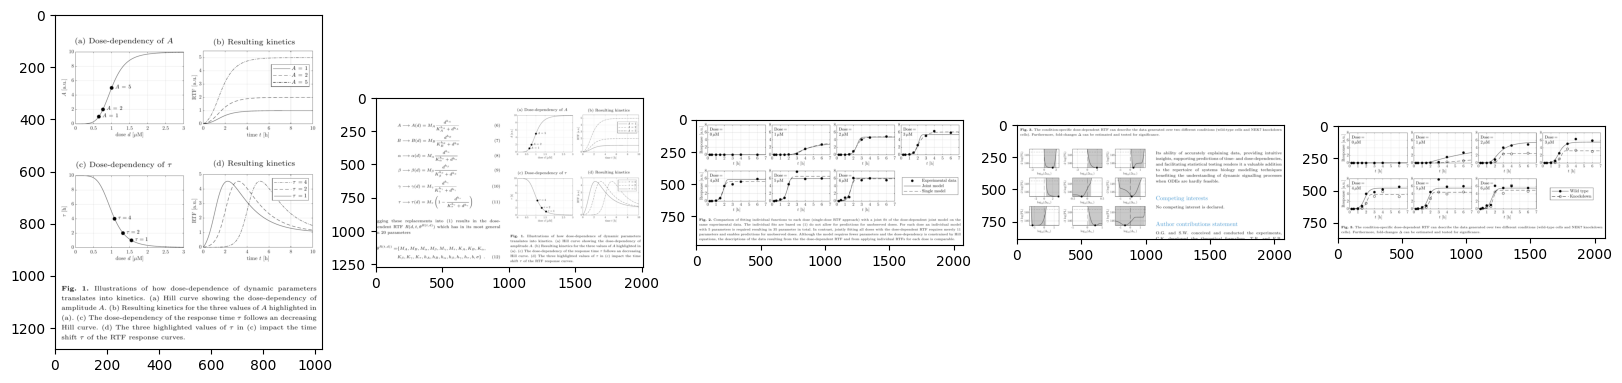

In [58]:
figs = []
for figure_id, figure_info in figures.items():
    figure, caption = figure_info['figure'], figure_info['caption']
    
    page_num = int(figure_id.split('_')[1])
    page_img = rasterzied_pdf[page_num].pilimage

    # get boundin box of figure + caption
    # process fractional bboxes to combine
    fig_bbox = figure.boxes[0]
    l, t, r, b = fig_bbox.l, fig_bbox.t, fig_bbox.w + fig_bbox.l, fig_bbox.h + fig_bbox.t
    caption_bbox = caption.boxes[0]
    l = min(l, caption_bbox.l)
    t = min(t, caption_bbox.t)
    r = max(r, caption_bbox.w + caption_bbox.l)
    b = max(b, caption_bbox.h + caption_bbox.t)
    combined_bbox = [l, t, r, b]

    # add margins of 0.01 to all sides
    combined_bbox = [combined_bbox[0] - 0.01, combined_bbox[1] - 0.01, combined_bbox[2] + 0.01, combined_bbox[3] + 0.01]
    # convert to pixels from fraction of page
    bbox = [combined_bbox[0] * page_img.size[0], combined_bbox[1] * page_img.size[1], combined_bbox[2] * page_img.size[0], combined_bbox[3] * page_img.size[1]]
    fig_img = page_img.crop(bbox)

    if fig_img.size[0] > 0 and fig_img.size[1] > 0:
        figs.append(fig_img)

import matplotlib.pyplot as plt
f, ax = plt.subplots(1, len(figs), figsize=(20, 10))    
for i, fig in enumerate(figs):
    ax[i].imshow(fig)


In [ ]:
figures: Dict[str, Path] = {}



# Save the figure
figure_path = output_folder / f"{figure_id}.png"
# TODO: Implement actual figure extraction using rasterizer
# This will depend on how your figures are stored in the document
figures[figure_id] = figure_path
print(figure)

# extract figure from rasterizer using bounding boxes
figure_image = rasterizer.extract_figure(figure, caption)

